In [32]:
import torch
from itertools import repeat
from typing import Optional, List, Tuple


class Relu:

    def __call__(self,
                 X: torch.Tensor):
        return torch.clamp(X, min=0)

    def backward(self,
                 dZ: torch.Tensor):
        return (dZ > 0).float()

    def parameters(self):
        return []


class Softmax:

    def __call__(self,
                 X: torch.Tensor,
                 dim: int):
        X = X - torch.max(X, dim=1, keepdims=True).values
        sof = torch.exp(X) / torch.sum(torch.exp(X), dim=dim, keepdims=True)
        return sof

    def parameters(self):
        return []


class OptimizerSG:

    def __init__(self,
                 params: Optional[List],
                 lr: float = 0.1):
        self.params = params
        self.lr = lr

    def step(self):
        for param in self.params:
            if param.grad is not None:
                param.data -= self.lr * param.grad


class Flatten:

    def __call__(self,
                 X: torch.Tensor):
        self.X = X
        self.out = X.view(X.shape[0], -1)
        return self.out

    def backward(self,
                 dZ: torch.Tensor):
        dX = dZ.view(self.X.size())
        return dX

    def parameters(self):
        return []


class Sequential:
    def __init__(self,
                 layers: List):
        self.layers = layers

    def __call__(self,
                 X: torch.Tensor):
        for layer in self.layers:
            X = layer(X)
        self.out = X
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


class Linear:
    def __init__(self,
                 fan_in: int,
                 fan_out: int,
                 bias=True):
        self.weight = torch.randn((fan_in, fan_out)) // fan_in ** 0.5
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self,
                 X: torch.Tensor):
        self.last_input = X
        self.out = X @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def backward(self, d_L_d_out):
        # d_L_d_weights = torch.matmul(self.last_input.t(), d_L_d_out)

        d_L_d_weights = self.last_input.T @ d_L_d_out
        d_L_d_biases = torch.sum(d_L_d_out, dim=0)
        d_L_d_input = d_L_d_out @ self.weight.T

        return d_L_d_input, d_L_d_weights, d_L_d_biases

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class CrossEntropyLoss:

    def __call__(self,
                 y_pred: torch.Tensor,
                 y_true: torch.Tensor
                 ):
        n_samples = y_pred.shape[0]
        log_likelihood = -torch.log(y_pred[range(n_samples), y_true])
        return torch.sum(log_likelihood) / n_samples

    def backward(self,
                 y_pred: torch.Tensor,
                 y_true: torch.Tensor
                 ):
        n_samples = y_pred.shape[0]
        softmax = Softmax()
        grad = softmax(y_pred, dim=1)
        grad[range(n_samples), y_true] -= 1
        grad = grad / n_samples
        return grad

    def paramerters(self):
        return []


class MaxPool2d:

    def __init__(self, kernel_size: int | Tuple[int, int], stride: int | Tuple[int, int]):
        self.kernel_size = tuple(kernel_size) if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = tuple(stride) if isinstance(stride, tuple) else (stride, stride)
        self.kh, self.kw = self.kernel_size
        self.sh, self.sw = self.stride
        self.padded_height, self.padded_width = None, None

    def prepare_submatrix(self, X: torch.Tensor):
        B, C, ih, iw = X.shape
        oh = (ih - self.kh) // self.sh + 1
        ow = (iw - self.kw) // self.sw + 1
        subM = X.unfold(2, self.kh, self.sh).unfold(3, self.kw, self.sw)
        return subM

    def __call__(self, X: torch.Tensor):
        self.X = X
        subM = self.prepare_submatrix(X)
        return subM.max(dim=-1).values.max(dim=-1).values

    def add_padding(self, x: torch.Tensor, padding: int):
        padding = tuple(repeat(padding, 4))
        batch_size, in_channels, original_height, original_width = x.size()
        padded_height = original_height + padding[0] + padding[1]
        padded_width = original_width + padding[2] + padding[3]

        if (self.padded_height and self.padded_width) is None:
            self.padded_height, self.padded_width = padded_height, padded_width

        padded_x = torch.zeros((batch_size, in_channels, padded_height, padded_width), dtype=x.dtype)
        padded_x[:, :, padding[0]:padding[0] + original_height, padding[2]:padding[2] + original_width] = x
        return padded_x

    def prepare_mask(self, subM: torch.Tensor):
        B, C, oh, ow, kh, kw = subM.shape
        a = torch.reshape(subM, (-1, kh * kw))
        idx = torch.argmax(a, dim=1)
        b = torch.zeros_like(a)
        b[torch.arange(b.shape[0]), idx] = 1
        mask = b.view(B, C, oh, ow, kh, kw)
        return mask

    def mask_dXp(self, mask: torch.Tensor, dz: torch.Tensor):
        dz_expanded = dz.unsqueeze(-1).unsqueeze(-1).expand_as(mask)
        dXp = dz_expanded * mask
        return dXp

    def maxpool_backprop(self, dZ: torch.Tensor, X: torch.Tensor):
        Xp = self.add_padding(X, self.kernel_size[0])
        subM = self.prepare_submatrix(Xp)
        mask = self.prepare_mask(subM)
        dXp = self.mask_dXp(mask, dZ)
        return dXp

    def padding_backward(self, dXp: torch.Tensor):
        B, C, ih, iw = self.X.shape
        dX = dXp[:, :, self.padded_height:ih, self.padded_width:iw]
        return dX

    def backward(self, dL_dout):
        Batch, num_channels, input_height, input_width = self.X.shape
        dL_dinput = torch.zeros_like(self.X)
        output_height = (input_height - self.kh) // self.sh + 1
        output_width = (input_width - self.kw) // self.sw + 1

        # Extract patches from the input tensor
        subM = self.prepare_submatrix(self.X)

        # Create the mask for the max pooling operation
        mask = self.prepare_mask(subM)

        # Expand dL_dout to match the shape of mask and perform element-wise multiplication
        dL_dout_expanded = dL_dout.unsqueeze(-1).unsqueeze(-1).expand_as(mask)
        dL_dinput_unfolded = dL_dout_expanded * mask

        # Combine the unfolded gradients to form the final gradient
        dL_dinput = dL_dinput_unfolded.contiguous().view(Batch, num_channels, output_height, output_width, self.kh,
                                                         self.kw)
        dL_dinput = dL_dinput.permute(0, 1, 2, 4, 3, 5).contiguous().view(Batch, num_channels, output_height * self.kh,
                                                                          output_width * self.kw)

        # Reduce the overlapping areas by summing them
        result = torch.zeros_like(self.X)
        for i in range(self.kh):
            for j in range(self.kw):
                result[:, :, i::self.kh, j::self.kw] += dL_dinput[:, :, i::self.kh, j::self.kw]

        return result

    def parameters(self):
        return []


class Conv2d:
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int,
                 stride: int = 1,
                 padding: int = 0,
                 dilation: int = 1,
                 groups: int = 1,
                 bias: bool = True) -> None:
        self.output_shape = None
        self.Ow = None
        self.Oh = None
        self.iw = None
        self.ih = None
        self.C = None
        self.B = None
        self.input_shape = None
        self.input_shape_x = None
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.kh, self.kw = self.kernel_size
        self.stride = stride if isinstance(stride, tuple) else (stride, stride)
        self.sh, self.sw = self.stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.weights, self.bias = self.initialise_parameters()

    def initialise_parameters(self, bias: bool = True):
        # return (torch.randn(self.out_channels, self.in_channels // self.groups, *self.kernel_size, requires_grad=True),
        #         torch.zeros(self.out_channels,self.Oh, self.Ow, requires_grad=True) if not bias else torch.randn(self.out_channels,self.Oh, self.Ow, requires_grad=True))
        return (torch.randn(self.out_channels, self.in_channels // self.groups, *self.kernel_size, requires_grad=True),
                torch.zeros(self.out_channels, requires_grad=True) if not bias else torch.randn(self.out_channels,
                                                                                                requires_grad=True))

    def get_padding_dimensions(self,
                               input_shape: torch.Tensor.size,
                               kernel_size: Tuple,
                               s=(1, 1),
                               padding: int | Tuple = None):
        if len(input_shape) == 4:
            B, C, ih, iw = input_shape
        if len(input_shape) == 3:
            C, ih, iw = input_shape

        kh, kw = kernel_size
        sh, sw = s
        if padding is None:
            p = self.padding
        else:
            p = padding

        if isinstance(p, int):
            pt, pb, pl, pr = p, p, p, p
        elif isinstance(p, tuple):
            ph, pw = p
            pt, pb = ph // 2, (ph + 1) // 2
            pl, pr = pw // 2, (pw + 1) // 2
        elif p == 'valid':
            pt, pb = 0, 0
            pl, pr = 0, 0

        elif p == 'same':
            ph = (sh - 1) * ih + kh - sh
            pw = (sw - 1) * iw + kw - sw

            pt, pb = ph // 2, (ph + 1) // 2
            pl, pr = pw // 2, (pw + 1) // 2
        else:
            raise ValueError(
                "Incorrect padding type. Allowed types are only 'same', 'valid', an integer or a tuple of length 2.")

        if len(input_shape) == 4:
            output_shape = (B, C, ih + pt + pb, iw + pl + pr)
        elif len(input_shape) == 4:
            output_shape = (C, ih + pt + pb + iw + pl + pr)

        return output_shape, (pt, pb, pl, pr)

    def get_dimensions(self, input_shape: torch.Tensor):
        self.input_shape_x = input_shape.shape
        self.input_shape, _ = self.get_padding_dimensions(self.input_shape_x, self.kernel_size, self.stride)

        if len(self.input_shape) == 3:
            self.C, self.ih, self.iw = self.input_shape
        elif len(self.input_shape) == 4:
            self.B, self.C, self.ih, self.iw = self.input_shape

        self.Oh = (self.ih - self.kh) // self.sh + 1
        self.Ow = (self.iw - self.kw) // self.sw + 1

        if len(self.input_shape) == 3:
            self.output_shape = (self.out_channels, self.Oh, self.Ow)
        elif len(self.input_shape) == 4:
            self.output_shape = (self.B, self.out_channels, self.Oh, self.Ow)

    def prepare_subMatrix(self, X: torch.Tensor, Kh: int, Kw: int, s):
        B, C, ih, iw = X.shape
        sh, sw = s

        Oh = (ih - Kh) // sh + 1
        Ow = (iw - Kw) // sw + 1

        strides = (C * ih * iw, iw * ih, iw * sh, sw, iw, 1)
        subM = torch.as_strided(X,
                                size=(B, C, Oh, Ow, Kh, Kw),
                                stride=strides)
        return subM

    def convolve(self, X: torch.Tensor, K: torch.Tensor, s: Tuple = (1, 1), mode: str = 'back'):
        F, Kc, Kh, Kw = K.shape
        subM = self.prepare_subMatrix(X, Kh, Kw, s)
        if mode == 'front':
            return torch.einsum('fckl,mcijkl->mfij', K, subM)
        elif mode == 'back':
            return torch.einsum('fdkl,mcijkl->mdij', K, subM)
        elif mode == 'param':
            return torch.einsum('mfkl,mcijkl->fcij', K, subM)

    def padding_forward(self, X: torch.Tensor, kernel_size, s=(1, 1), padding=None) -> torch.Tensor:
        self.input_shape_before_padding = X.shape
        B, C, ih, iw = self.input_shape_before_padding
        self.output_shape_padded, (self.pt, self.pb, self.pl, self.pr) = self.get_padding_dimensions(
            self.input_shape_before_padding, kernel_size, s, padding=padding)

        zeros_r = torch.zeros((B, C, ih, self.pr), dtype=X.dtype, device=X.device)
        zeros_l = torch.zeros((B, C, iw, self.pl), dtype=X.dtype, device=X.device)
        zeros_t = torch.zeros((B, C, self.pt, iw + self.pl + self.pr), dtype=X.dtype, device=X.device)
        zeros_b = torch.zeros((B, C, self.pb, iw + self.pl + self.pr), dtype=X.dtype, device=X.device)

        Xp = torch.concat((X, zeros_r), dim=3)
        Xp = torch.concat((zeros_l, Xp), dim=3)
        Xp = torch.concat((zeros_t, Xp), dim=2)
        Xp = torch.concat((Xp, zeros_b), dim=2)

        return Xp

    def padding_backward(self, dXp: torch.Tensor):
        B, C, ih, iw = self.input_shape
        dX = dXp[:, :, self.pt:self.pt + ih, self.pl:self.pl + iw]
        return dX

    def dilate2D(self, X: torch.Tensor, Dr=(1, 1)) -> torch.Tensor:
        dh, dw = Dr
        B, C, H, W = X.shape

        if dw > 1:
            Xd_w = torch.zeros((B, C, H, W + (W - 1) * (dw - 1)), dtype=X.dtype, device=X.device)
            Xd_w[:, :, :, ::dw] = X
        else:
            Xd_w = X

        if dh > 1:
            Xd_h = torch.zeros((B, C, H + (H - 1) * (dh - 1), Xd_w.shape[-1]), dtype=X.dtype, device=X.device)
            Xd_h[:, :, ::dh, :] = Xd_w
        else:
            Xd_h = Xd_w

        return Xd_h

    def dZ_D_dX(self, dZ_D: torch.Tensor, ih: int, iw: int) -> torch.Tensor:
        _, _, Hd, Wd = dZ_D.shape
        ph = ih - Hd + self.kh - 1
        pw = iw - Wd + self.kw - 1

        dZ_Dp = self.padding_forward(dZ_D, self.kernel_size, self.stride, (ph, pw))
        k_rotated = self.weights.flip([2, 3])
        dXp = self.convolve(dZ_Dp, k_rotated, mode='back')
        dX = self.padding_backward(dXp)

        return dX

    def __call__(self, X: torch.Tensor) -> torch.Tensor:
        self.X = X
        self.get_dimensions(X)
        Xp = self.padding_forward(X, self.kernel_size, self.stride, self.padding)
        self.Z = self.convolve(Xp, self.weights, self.stride, mode='front')

        if self.bias is not None:
            return self.Z + self.bias.view(1, -1, 1, 1)  # sum should be done on the last layer

        return self.Z

    def backward(self, dZ: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        Xp = self.padding_forward(self.X, self.kernel_size, self.stride)

        B, C, ih, iw = Xp.shape

        # Dilate dZ (dZ -> dZ_D)
        dZ_D = self.dilate2D(dZ, Dr=self.stride)
        dX = self.dZ_D_dX(dZ_D, ih, iw)

        # Gradient K
        _, _, Hd, Wd = dZ_D.shape

        ph = self.ih - Hd - self.kh + 1
        pw = self.iw - Wd - self.kw + 1

        dZ_Dp = self.padding_forward(dZ_D, self.kernel_size, self.stride, padding=(ph, pw))
        self.dK = self.convolve(Xp, dZ_Dp, mode='param')

        # gradient db
        self.db = torch.sum(dZ, dim=[0,2,3])

        return dX, self.dK, self.db

    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])


def backward(logits):
    dlogits = loss.backward(logits,y)
    d_L_d_input, d_L_d_weights, d_L_d_biases = classifier.layers[-1].backward(dlogits)
    dflatten = classifier.layers[-2].backward(d_L_d_input)

    # backward pass through maxpool
    dmaxp2 = model.layers[-1].backward(dflatten)
    drel2 = model.layers[-2].backward(dmaxp2)
    dconv2, dconv_w2, dconv_b2 = model.layers[-3].backward(drel2)
    drel1 = model.layers[-3].backward(dconv2)
    dconv1, dconv_w1, dconv_b1 = model.layers[-5].backward(drel2)

    grads = [dconv_w1, dconv_b1, dconv_w2, dconv_b2,
             d_L_d_weights, d_L_d_biases]
    return grads


class Optimizer:

    def __init__(self, optimizer_type: str = None):
        if optimizer_type is None:
            self.optimizer_type = 'SGD'
        else:
            self.optimizer_type = optimizer_type

    def SGD(self,
            parameters: List[torch.Tensor],
            grads: List[torch.Tensor],
            momentum: int = 0.1,
            lr: float = 0.1):
        for p, grad in zip(parameters, grads):                                                                                                                                    
            p.data += -lr * grad
        return parameters


In [40]:
print(torch.cuda.is_available())
model = Sequential([
    Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=1, dilation=1),
    Relu(),
    Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1, dilation=1),
    Relu(),
    MaxPool2d(2, 2),
])
classifier = Sequential([
    Flatten(),
    Linear(fan_in=40960,
           fan_out=3)
])

# parameter init
with torch.no_grad():
    classifier.layers[-1].weight *= 0.1

num_epochs = 10

parameters = model.parameters() + classifier.parameters()
print(sum(p.nelement() for p in parameters))  # number of parameters in total
for p in parameters:
    p.requires_grad = True

y = torch.randint(0, 3, (30,))
x = torch.randn(30, 3, 128, 128)
losses = []


False
124073


In [41]:
num_epochs = 10
for i in range(num_epochs):
    logits = classifier(model(x))

    loss = CrossEntropyLoss()
    lossi = loss(logits, y)
    for p in parameters:
        p.grad = None
    grads = backward(logits)
    optimizer = Optimizer()
    parameters = optimizer.SGD(parameters=parameters, grads=grads)
    losses.append(lossi)
    print(lossi)

print(losses)

tensor(nan, grad_fn=<DivBackward0>)
tensor(nan, grad_fn=<DivBackward0>)
tensor(nan, grad_fn=<DivBackward0>)
tensor(nan, grad_fn=<DivBackward0>)
tensor(nan, grad_fn=<DivBackward0>)
tensor(nan, grad_fn=<DivBackward0>)
tensor(nan, grad_fn=<DivBackward0>)
tensor(nan, grad_fn=<DivBackward0>)
tensor(nan, grad_fn=<DivBackward0>)
tensor(nan, grad_fn=<DivBackward0>)
[tensor(nan, grad_fn=<DivBackward0>), tensor(nan, grad_fn=<DivBackward0>), tensor(nan, grad_fn=<DivBackward0>), tensor(nan, grad_fn=<DivBackward0>), tensor(nan, grad_fn=<DivBackward0>), tensor(nan, grad_fn=<DivBackward0>), tensor(nan, grad_fn=<DivBackward0>), tensor(nan, grad_fn=<DivBackward0>), tensor(nan, grad_fn=<DivBackward0>), tensor(nan, grad_fn=<DivBackward0>)]


In [14]:
import matplotlib.pyplot as plt

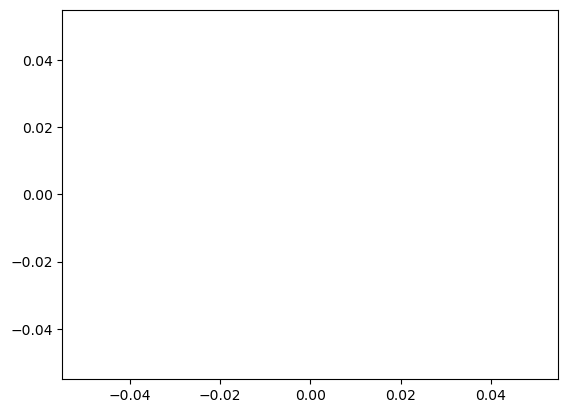

In [31]:
losses_np = [ten.detach().numpy() for ten in losses]
plt.plot(losses_np)